# Data Set Information

The data is related to direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required to assess if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

The classification goal is to predict if the client will subscribe (yes/no) to a term deposit (variable y).

## Attribute Information

### Input variables:

1. **age (numeric)**
2. **job:** type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. **marital:** marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. **education:** (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. **default:** has credit in default? (categorical: 'no','yes','unknown')
6. **housing:** has housing loan? (categorical: 'no','yes','unknown')
7. **loan:** has a personal loan? (categorical: 'no','yes','unknown')

### Related to the last contact of the current campaign:

8. **contact:** contact communication type (categorical: 'cellular','telephone')
9. **month:** last contact month of the year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. **day_of_week:** last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. **duration:** last contact duration, in seconds (numeric). *Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.*

### Other attributes:

12. **campaign:** number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. **pdays:** number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means the client was not previously contacted)
14. **previous:** number of contacts performed before this campaign and for this client (numeric)
15. **poutcome:** outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

### Social and economic context attributes:

16. **emp.var.rate:** employment variation rate - quarterly indicator (numeric)
17. **cons.price.idx:** consumer price index - monthly indicator (numeric)
18. **cons.conf.idx:** consumer confidence index - monthly indicator (numeric)
19. **euribor3m:** euribor 3-month rate - daily indicator (numeric)
20. **nr.employed:** number of employees - quarterly indicator (numeric)

### Output variable (desired target):

21. **y:** has the client subscribed to a term deposit? (binary: 'yes','no')


# 1. Importing Libraries and Datasets

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 


from IPython.display import display, HTML
from IPython.display import Image

In [2]:
df=pd.read_csv("bank-additional-full.csv",sep=';')
df=df.drop(['duration'],axis=1)
df1=df.copy()

# 2. Exploratory Data Analysis (EDA)

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(f"Rows: {dataframe.shape[0]}")
    print(f"Columns: {dataframe.shape[1]}")

    print("\n##################### Types #####################")
    print(dataframe.dtypes)

    print("\n##################### Head #####################")
    print(dataframe.head(head))

    print("\n##################### Tail #####################")
    print(dataframe.tail(head))

    print("\n##################### NA #####################")
    print(dataframe.isnull().sum())

    print("\n##################### Quantiles #####################")
    print(dataframe.describe().T)

In [4]:
check_df(df)

##################### Shape #####################
Rows: 41188
Columns: 20

##################### Types #####################
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

##################### Head #####################
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  

In [5]:
##################################################
# Capturing numerical and Categorical variables 
##################################################

# This function analyzes the columns in a dataframe and determines categorical, numerical, and other columns.

def grab_col_names(dataframe, cat_th=8, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() >= car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car

In [6]:
cat_cols, num_cols, cat_but_car = grab_col_names(df) 

Observations: 41188
Variables: 20
cat_cols: 11
num_cols: 9
cat_but_car: 0
num_but_cat: 0


In [7]:
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

In [8]:
num_cols

['age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [9]:
#########################################
# Analysis of Categorical Variables
#########################################

# This function performs the analysis and visualization of categorical variables.

def cat_summary(dataframe, col_name, plot=True):
    value_counts = dataframe[col_name].value_counts()
    ratio = 100 * value_counts / len(dataframe)
    
    if plot:
        plt.figure(figsize=(8, 4))
        
        
        custom_palette = sns.color_palette("Set2", len(value_counts))
        
        sns.countplot(y=dataframe[col_name], data=dataframe, order=value_counts.index, palette=custom_palette)
        plt.title(f"{col_name} Distribution")
        plt.xlabel("Count")
        plt.ylabel(col_name)
        plt.xticks(rotation=0)
        
        for i, v in enumerate(value_counts.values):
            plt.text(v + 1, i, f"{v} ({ratio.iloc[i]:.2f}%)", va='center')
        
        plt.show()

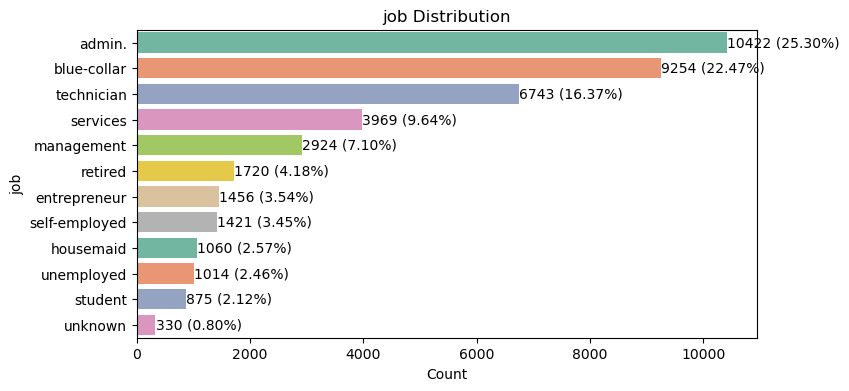

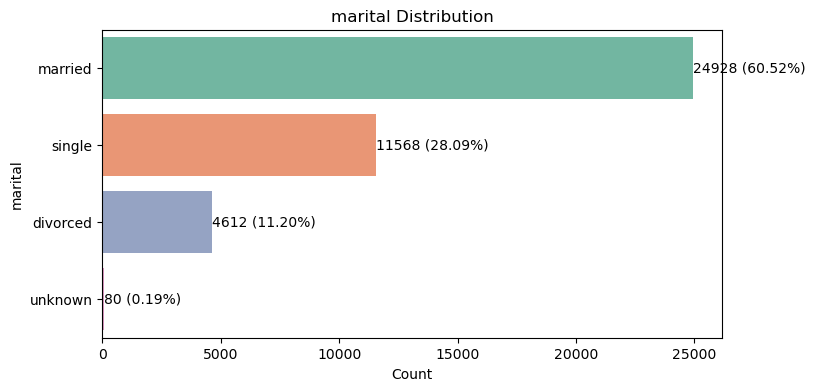

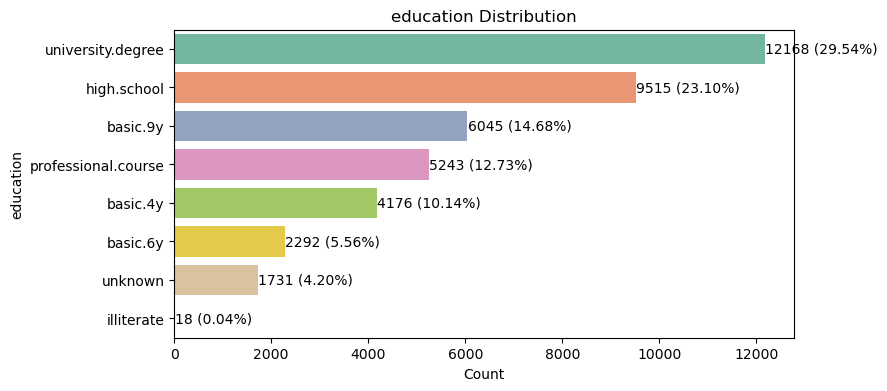

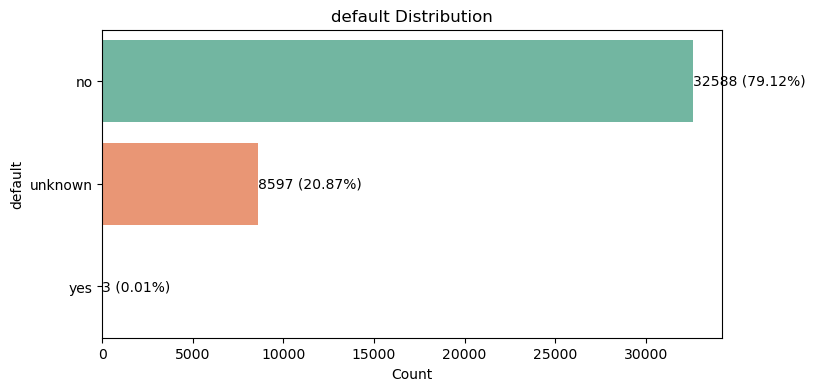

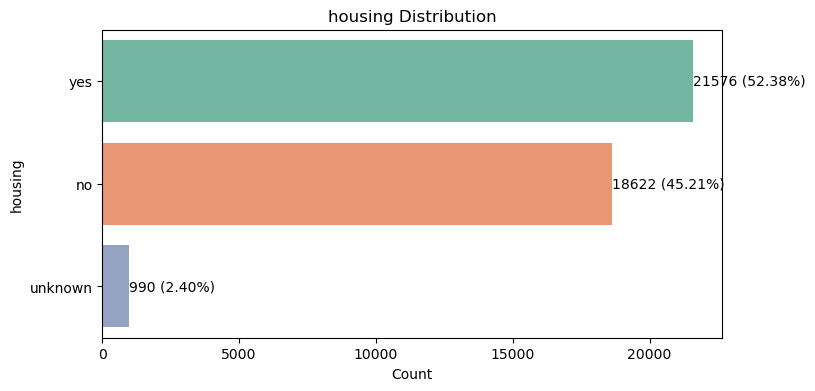

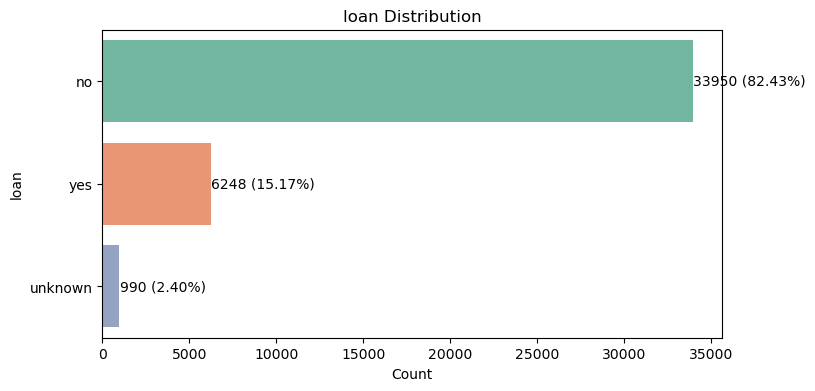

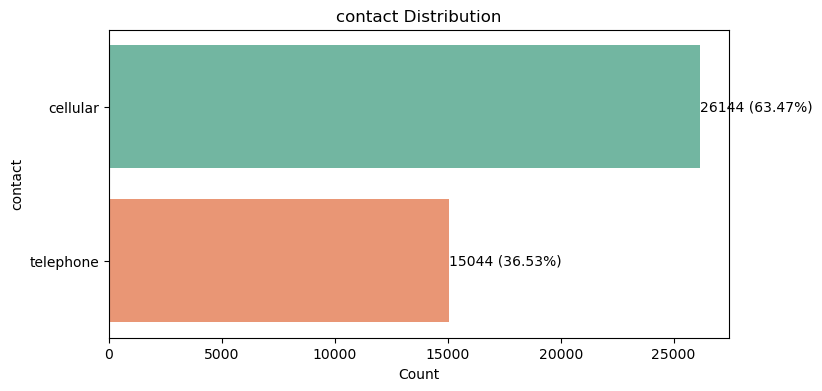

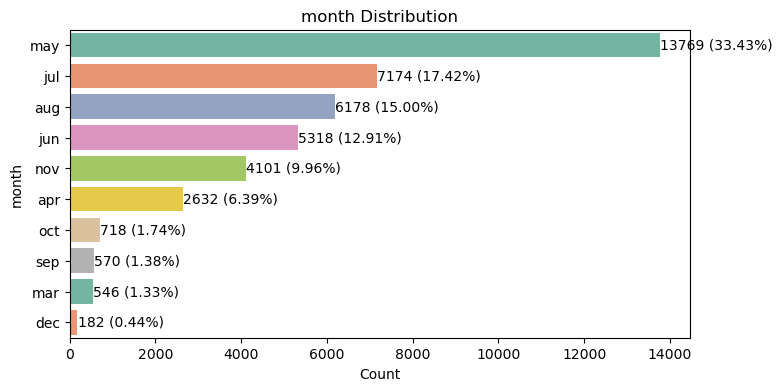

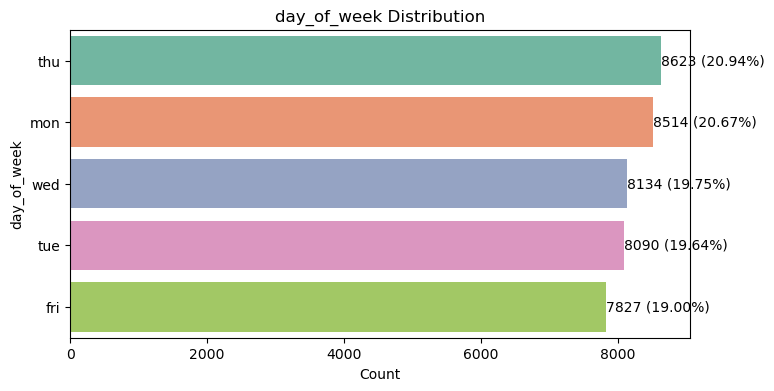

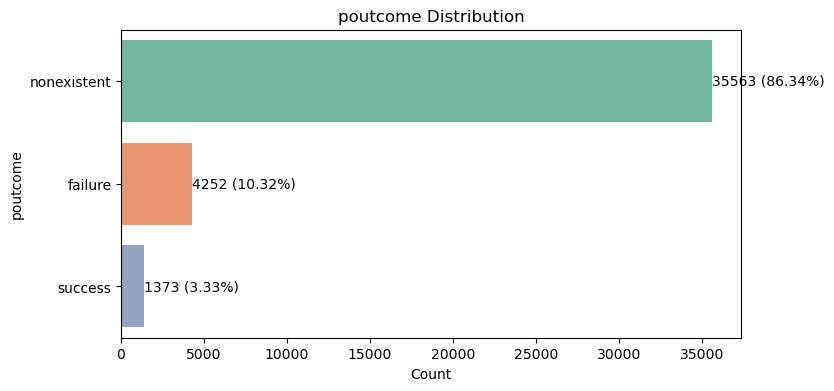

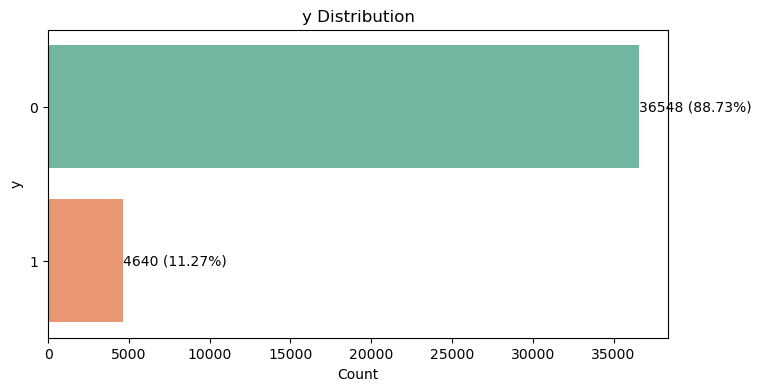

In [18]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

In [11]:
########################################
# Analysis of Numerical Variables
########################################

# This function performs the analysis of numerical variables and, if desired, visualizes them.

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    summary = dataframe[numerical_col].describe(quantiles)

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(18, 4))
        
        # Plot histogram
        dataframe[numerical_col].hist(bins=20, ax=axes[0], color="lightgreen")
        axes[0].set_xlabel(numerical_col)
        axes[0].set_title(numerical_col)
        
        # Displaying summary statistics as text
        summary_text = "\n".join([f'{col}: {value:.3f}' for col, value in summary.items()])
        axes[1].text(0.5, 0.5, summary_text, fontsize=12, va='center', ha='left', linespacing=1.5)
        axes[1].axis('off')  
        
        plt.show()
        print("################################################################")

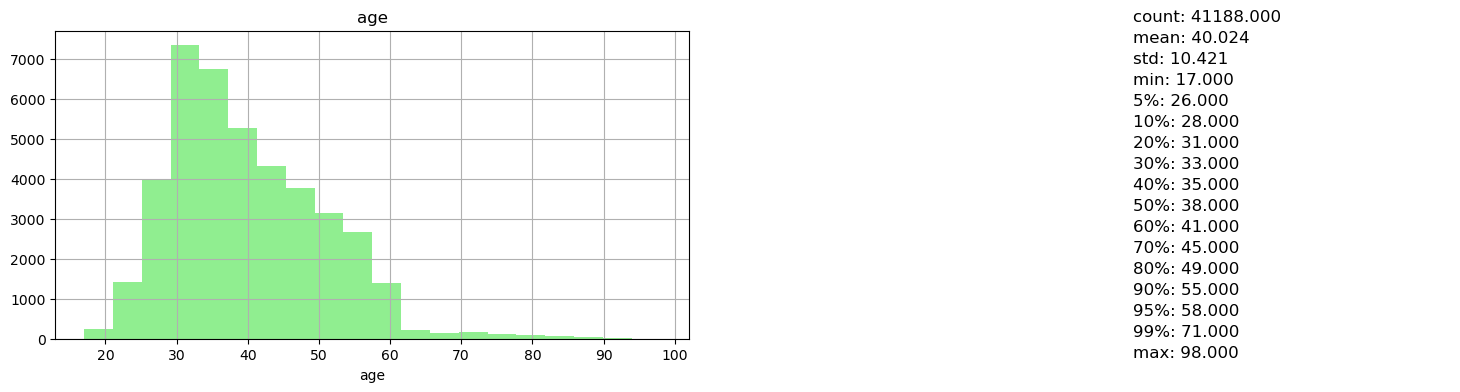

################################################################


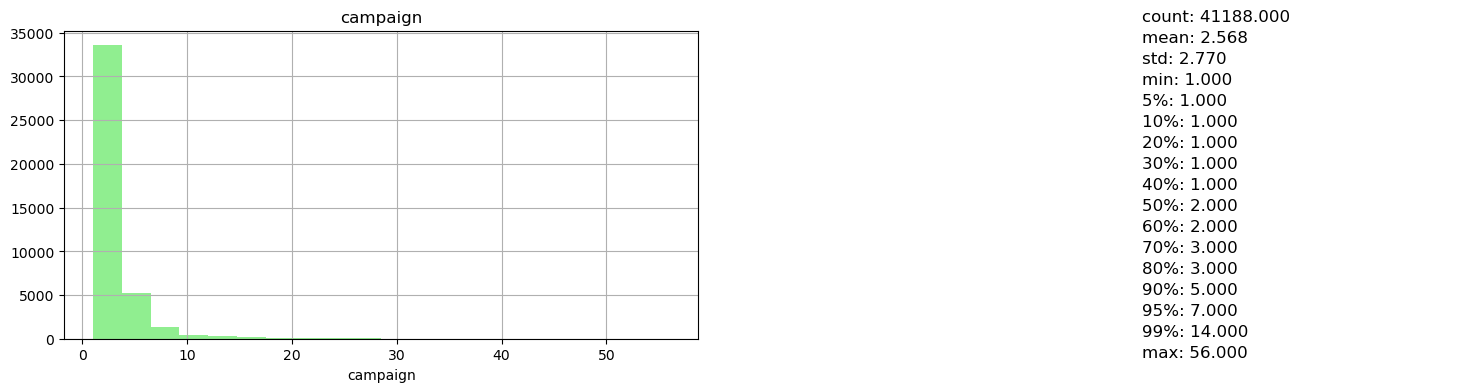

################################################################


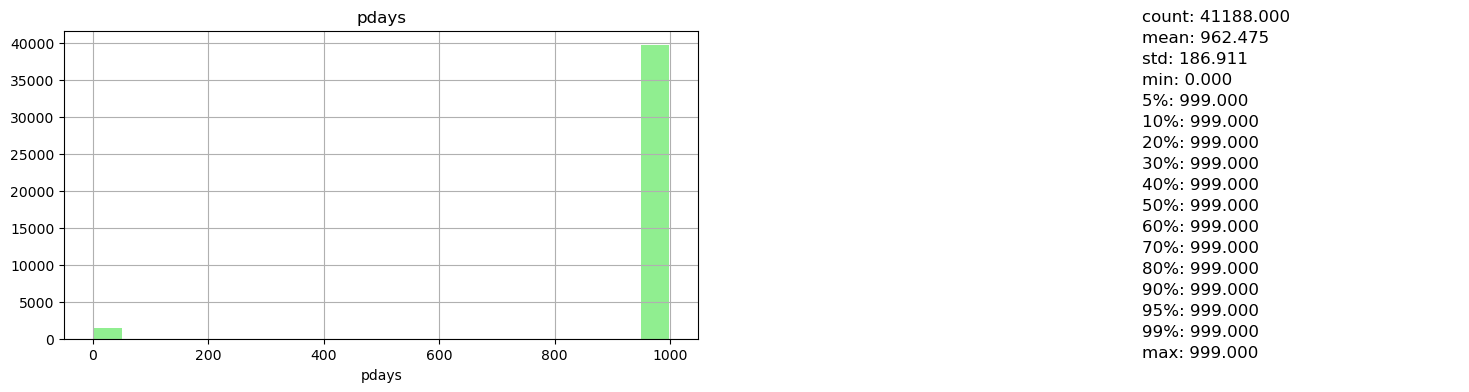

################################################################


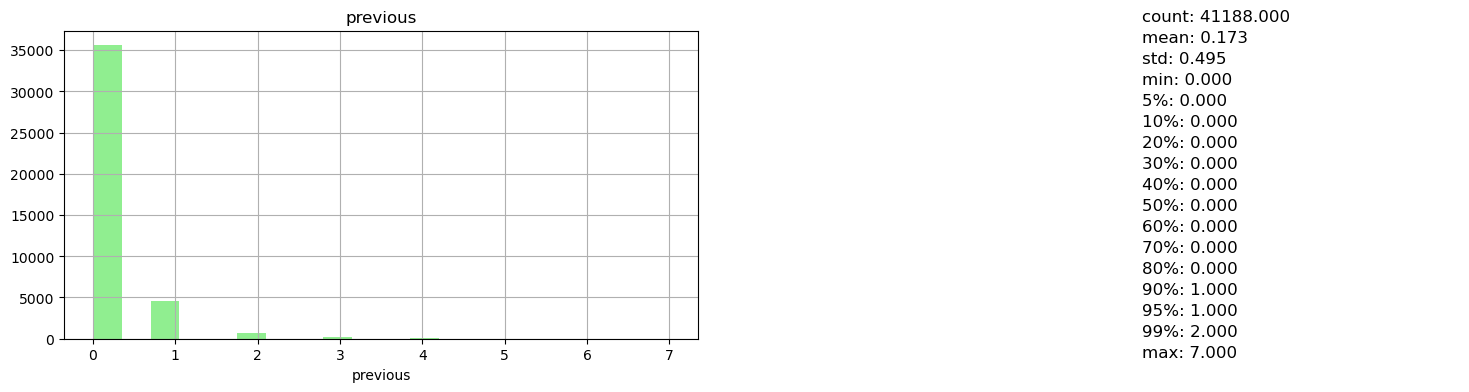

################################################################


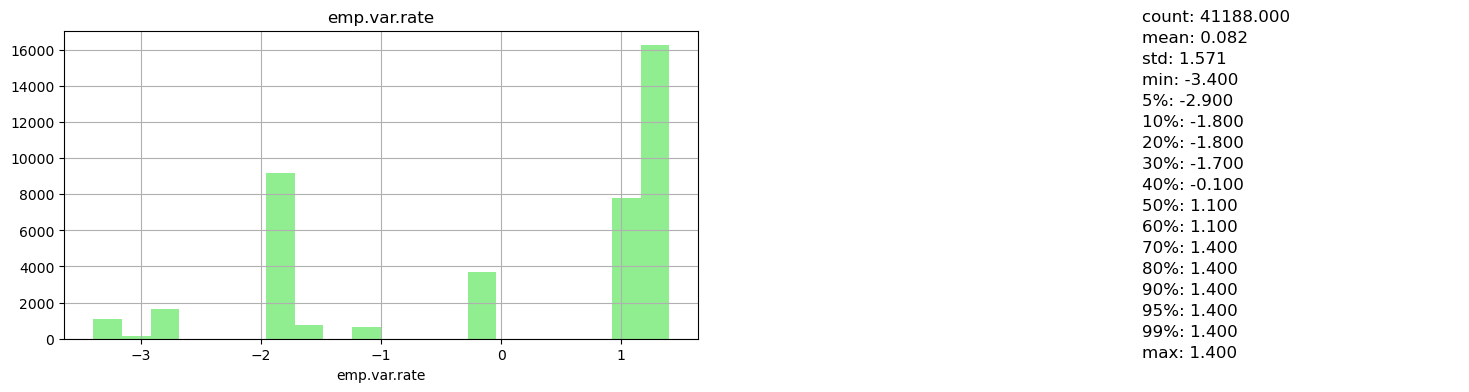

################################################################


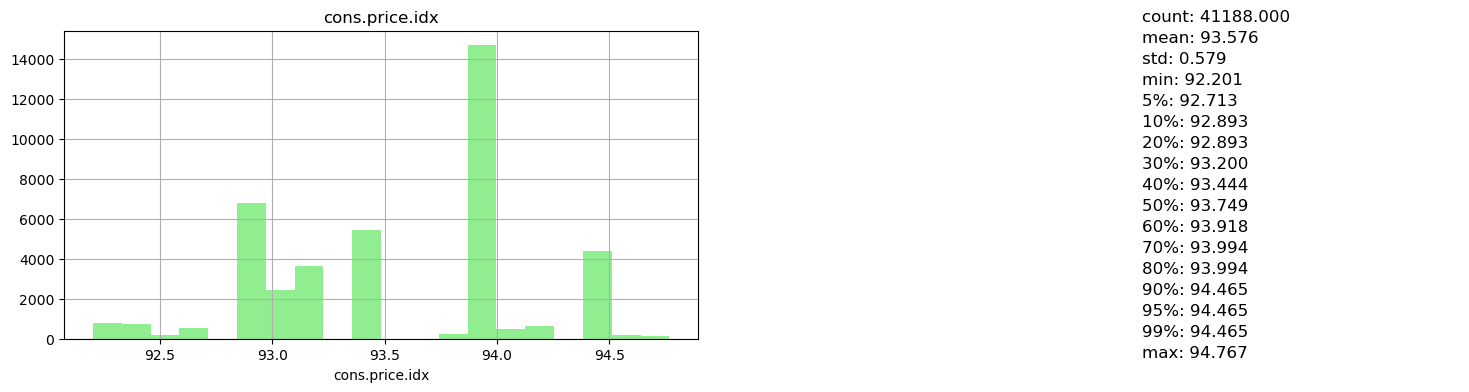

################################################################


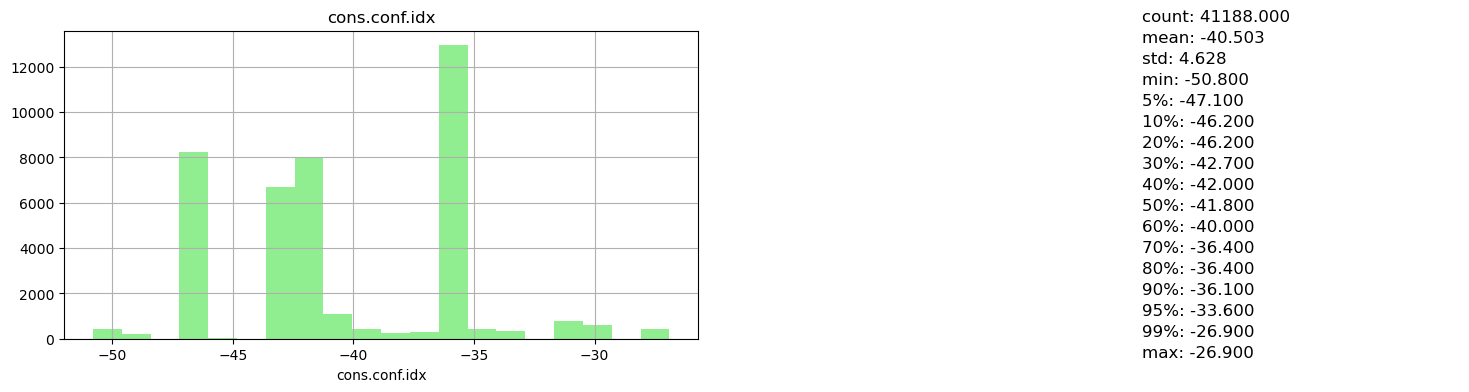

################################################################


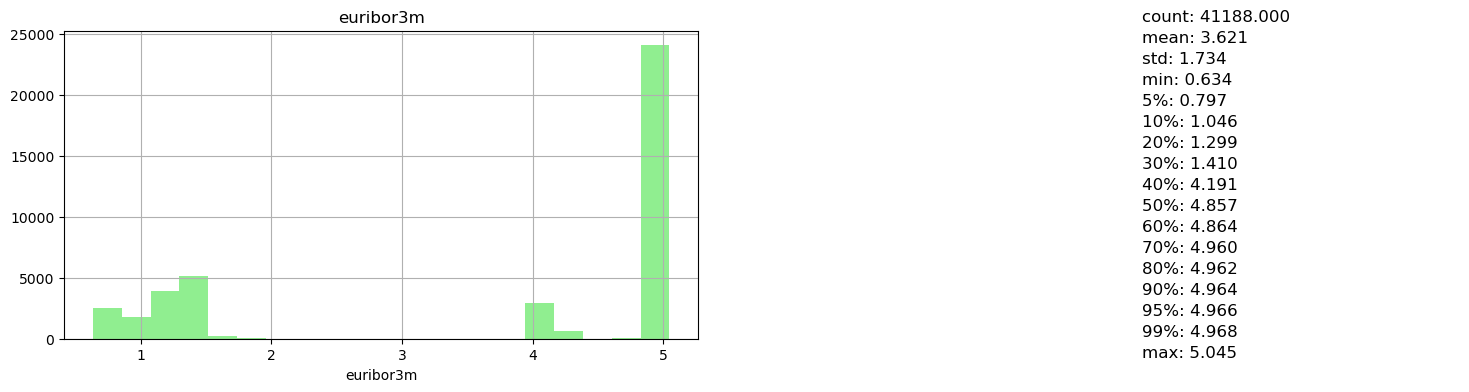

################################################################


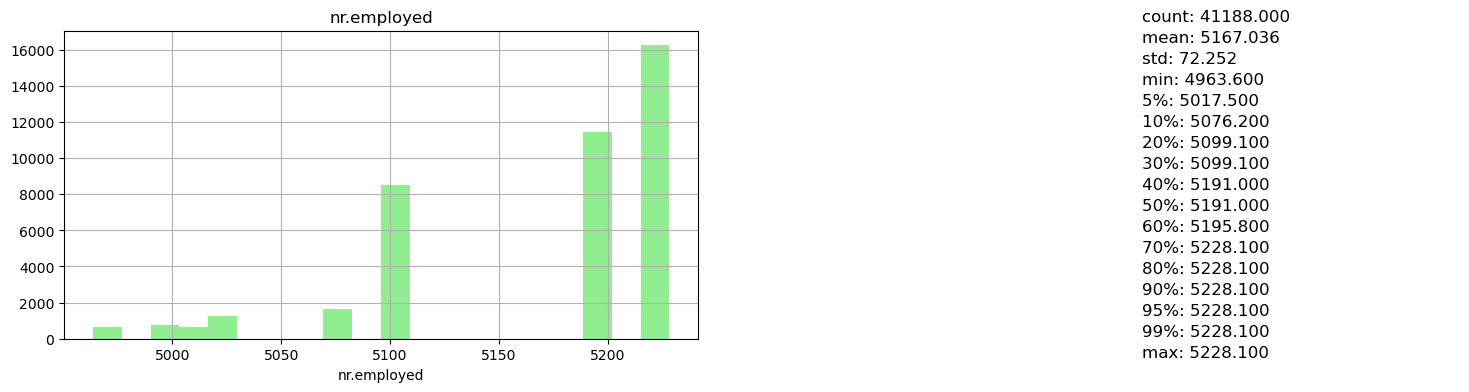

################################################################


In [12]:
for col in num_cols:
    num_summary(df, col, plot=True) 

In [13]:
##################    Target Variable Analysis    ##################

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
    print("##########################################")

for col in num_cols:
    target_summary_with_num(df, "y", col)

           age
y             
no   39.911185
yes  40.913147


##########################################
     campaign
y            
no   2.633085
yes  2.051724


##########################################
          pdays
y              
no   984.113878
yes  792.035560


##########################################
     previous
y            
no   0.132374
yes  0.492672


##########################################
     emp.var.rate
y                
no       0.248875
yes     -1.233448


##########################################
     cons.price.idx
y                  
no        93.603757
yes       93.354386


##########################################
     cons.conf.idx
y                 
no      -40.593097
yes     -39.789784


##########################################
     euribor3m
y             
no    3.811491
yes   2.123135


##########################################
     nr.employed
y               
no   5176.166600
yes  5095.115991


##########################################


In [14]:
df["y"] = df["y"].map({"no": 0, "yes": 1})

In [15]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"y_mean": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "y", col)

                 y_mean
job                    
admin.         0.129726
blue-collar    0.068943
entrepreneur   0.085165
housemaid      0.100000
management     0.112175
retired        0.252326
self-employed  0.104856
services       0.081381
student        0.314286
technician     0.108260
unemployed     0.142012
unknown        0.112121


            y_mean
marital           
divorced  0.103209
married   0.101573
single    0.140041
unknown   0.150000


                       y_mean
education                    
basic.4y             0.102490
basic.6y             0.082024
basic.9y             0.078246
high.school          0.108355
illiterate           0.222222
professional.course  0.113485
university.degree    0.137245
unknown              0.145003


          y_mean
default         
no       0.12879
unknown  0.05153
yes      0.00000


           y_mean
housing          
no       0.108796
unknown  0.108081
yes      0.116194


           y_mean
loan             
no       0.113402
unknown  0.

In [16]:
##################################
# Outlier Analysis
##################################

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
  

for col in num_cols:
    print(col, check_outlier(df, col))

age False
campaign True
pdays True
previous True
emp.var.rate False
cons.price.idx False
cons.conf.idx False
euribor3m False
nr.employed False
